In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import max, min

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [2]:
spark = SparkSession.builder.getOrCreate()

In [4]:
data_path = 'Data/cleaned_data'

In [5]:
df1 = spark.read.format("csv").option('header','true').load(data_path)

In [7]:
df1.createOrReplaceTempView('FrameId')

23/02/03 11:54:47 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [8]:
df_max_min = spark.sql("SELECT gameId, playId, AVG(prePenaltyPlayResult), count(frameId) as count_frames \
                        FROM (\
                        SELECT DISTINCT gameId, playId, prePenaltyPlayResult, frameId FROM FrameId)\
                        GROUP BY gameId, playId \
                        ORDER BY playId, count(frameId) DESC")
df_max_min = df_max_min.toPandas()

<AxesSubplot:xlabel='count_frames', ylabel='avg(prePenaltyPlayResult)'>

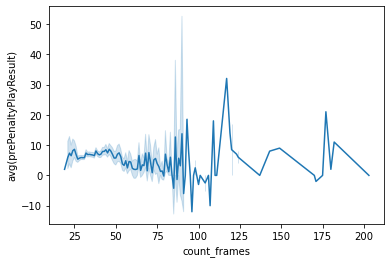

In [9]:
sns.lineplot(x='count_frames', y='avg(prePenaltyPlayResult)', data=df_max_min)

In [139]:
x = stats.pearsonr(df_max_min['count_frames'], df_max_min['avg(prePenaltyPlayResult)'])
x

(-0.0653074535590892, 2.3732777738060244e-09)

In [10]:
df1.createOrReplaceTempView('pass_cov')
df_pass_cov = spark.sql("SELECT gameId, playId, pff_passCoverage, prePenaltyPlayResult, passResult, playResult\
                        FROM ( \
                        SELECT DISTINCT gameId, playId, pff_passCoverage, prePenaltyPlayResult, passResult, playResult\
                        FROM pass_cov \
                        GROUP BY gameId, playId, pff_passCoverage, prePenaltyPlayResult, passResult, playResult \
                        ORDER BY pff_passCoverage, prePenaltyPlayResult, playResult) \
                       ")
df_pass_cov.show()

+----------+------+----------------+--------------------+----------+----------+
|    gameId|playId|pff_passCoverage|prePenaltyPlayResult|passResult|playResult|
+----------+------+----------------+--------------------+----------+----------+
|2021101708|  2939|           2-Man|                  -1|         S|        -1|
|2021100301|  1112|           2-Man|                 -10|         S|       -10|
|2021091905|  3553|           2-Man|                 -10|         S|       -10|
|2021102405|  2903|           2-Man|                 -10|         S|       -10|
|2021102500|  3945|           2-Man|                 -10|         S|       -10|
|2021101703|  3773|           2-Man|                 -11|         S|       -11|
|2021091211|   902|           2-Man|                 -11|         S|       -11|
|2021100305|  3091|           2-Man|                  -3|         C|        -3|
|2021102405|   507|           2-Man|                  -5|         S|        -5|
|2021100311|  1312|           2-Man|    

In [11]:
df_pass_cov = df_pass_cov.toPandas()
df_pass_cov

,gameId,playId,pff_passCoverage,prePenaltyPlayResult,passResult,playResult
0,2021101708,2939,2-Man,-1,S,-1
1,2021091905,3553,2-Man,-10,S,-10
2,2021100301,1112,2-Man,-10,S,-10
3,2021102405,2903,2-Man,-10,S,-10
4,2021102500,3945,2-Man,-10,S,-10
...,...,...,...,...,...,...
8336,2021101701,2212,Red Zone,9,C,9
8337,2021101708,3160,Red Zone,9,C,9
8338,2021102406,1870,Red Zone,9,C,9
8339,2021103105,762,Red Zone,9,C,9


In [12]:
df_pass_cov['prePenaltyPlayResult'] = df_pass_cov['prePenaltyPlayResult'].astype(int)
df_pass_cov['playResult'] = df_pass_cov['playResult'].astype(int)


In [13]:
df_pass_cov.sort_values(by=['prePenaltyPlayResult', 'playResult'], inplace=True)

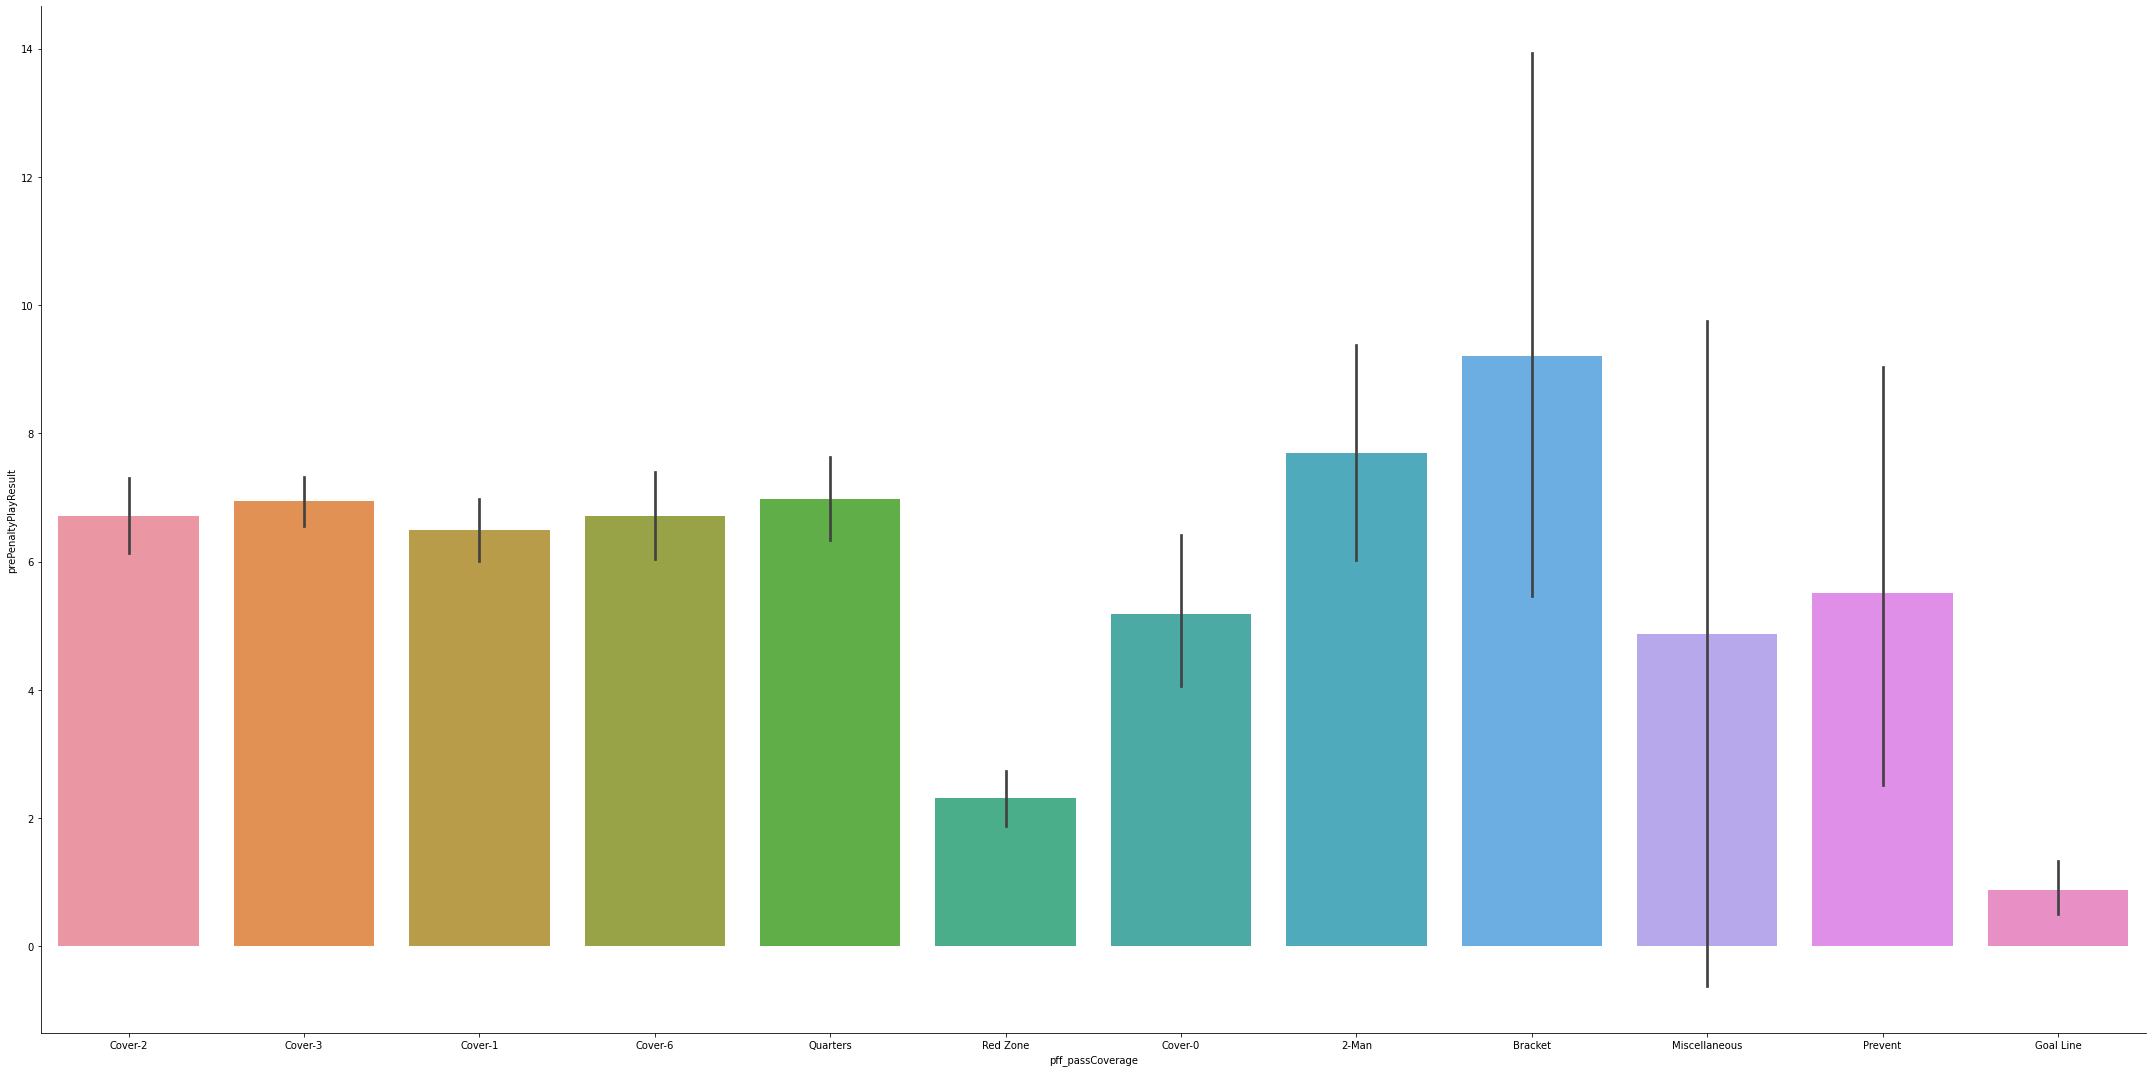

In [14]:
sns.catplot(x='pff_passCoverage', y='prePenaltyPlayResult', kind='bar',data=df_pass_cov, height=15, aspect=2)

In [84]:
df1.createOrReplaceTempView('eda_cov')
df_eda_cov = spark.sql("SELECT gameId, playId, pff_blockType, yardsToGo,pff_passCoverageType,preSnapHomeScore,offenseFormation,defendersInBox,dropBackType,preSnapVisitorScore,prePenaltyPlayResult, passResult, playResult,\
                        preSnapHomeScore - preSnapVisitorScore as hometeamupdown\
                        FROM ( \
                        SELECT gameId, playId, pff_blockType,yardsToGo,pff_passCoverageType, preSnapHomeScore,preSnapVisitorScore,dropBackType,defendersInBox,offenseFormation,prePenaltyPlayResult, passResult, playResult\
                        FROM pass_cov \
                        GROUP BY gameId, playId, pff_blockType,yardsToGo,pff_passCoverageType, preSnapHomeScore,preSnapVisitorScore,dropBackType,defendersInBox,offenseFormation,prePenaltyPlayResult, passResult, playResult \
                        ORDER BY yardsToGo, preSnapHomeScore, defendersInBox, preSnapVisitorScore, prePenaltyPlayResult, playResult\
                      )")
df_eda_cov = df_eda_cov.toPandas()
df_eda_cov

,gameId,playId,pff_blockType,yardsToGo,pff_passCoverageType,preSnapHomeScore,offenseFormation,defendersInBox,dropBackType,preSnapVisitorScore,prePenaltyPlayResult,passResult,playResult,hometeamupdown
0,2021092604,1330,PT,0,Other,0,SHOTGUN,11.0,None,12,0,C,0,-12.0
1,2021092604,1330,PP,0,Other,0,SHOTGUN,11.0,None,12,0,C,0,-12.0
2,2021092604,1330,None,0,Other,0,SHOTGUN,11.0,None,12,0,C,0,-12.0
3,2021103103,2868,PP,0,Other,10,EMPTY,4.0,None,9,0,I,0,1.0
4,2021103103,2868,None,0,Other,10,EMPTY,4.0,None,9,0,I,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30631,2021102401,1007,PT,9,Zone,7,EMPTY,8.0,TRADITIONAL,7,10,C,10,0.0
30632,2021102401,1007,PP,9,Zone,7,EMPTY,8.0,TRADITIONAL,7,10,C,10,0.0
30633,2021091202,1885,None,9,Man,9,SHOTGUN,5.0,TRADITIONAL,0,14,C,14,9.0
30634,2021091202,1885,PP,9,Man,9,SHOTGUN,5.0,TRADITIONAL,0,14,C,14,9.0


In [85]:
# df_eda_cov['defendersInBox'] = df_eda_cov.astype({'defendersInBox':'int'})
df_eda_cov['defendersInBox'].value_counts()

df_eda_cov.loc[df_eda_cov["defendersInBox"] == "1.0", "defendersInBox"] = int(1)
df_eda_cov.loc[df_eda_cov["defendersInBox"] == "2.0", "defendersInBox"] = int(2)
df_eda_cov.loc[df_eda_cov["defendersInBox"] == "3.0", "defendersInBox"] = int(3)
df_eda_cov.loc[df_eda_cov["defendersInBox"] == "4.0", "defendersInBox"] = int(4)
df_eda_cov.loc[df_eda_cov["defendersInBox"] == "5.0", "defendersInBox"] = int(5)
df_eda_cov.loc[df_eda_cov["defendersInBox"] == "6.0", "defendersInBox"] = int(6)
df_eda_cov.loc[df_eda_cov["defendersInBox"] == "7.0", "defendersInBox"] = int(7)
df_eda_cov.loc[df_eda_cov["defendersInBox"] == "8.0", "defendersInBox"] = int(8)
df_eda_cov.loc[df_eda_cov["defendersInBox"] == "9.0", "defendersInBox"] = int(9)
df_eda_cov.loc[df_eda_cov["defendersInBox"] == "10.0", "defendersInBox"] = int(10)
df_eda_cov.loc[df_eda_cov["defendersInBox"] == "11.0", "defendersInBox"] = int(11)

df_eda_cov.dtypes

gameId                   object
playId                   object
pff_blockType            object
yardsToGo                object
pff_passCoverageType     object
preSnapHomeScore         object
offenseFormation         object
defendersInBox           object
dropBackType             object
preSnapVisitorScore      object
prePenaltyPlayResult     object
passResult               object
playResult               object
hometeamupdown          float64
dtype: object

In [86]:

df_eda_cov['defendersInBox'] = pd.to_numeric(df_eda_cov['defendersInBox'])

df_eda_cov.dtypes

gameId                   object
playId                   object
pff_blockType            object
yardsToGo                object
pff_passCoverageType     object
preSnapHomeScore         object
offenseFormation         object
defendersInBox          float64
dropBackType             object
preSnapVisitorScore      object
prePenaltyPlayResult     object
passResult               object
playResult               object
hometeamupdown          float64
dtype: object

In [87]:
df_eda_cov['yardsToGo'] = df_eda_cov['yardsToGo'].astype(int)
df_eda_cov['preSnapHomeScore'] = df_eda_cov['preSnapHomeScore'].astype(int)
# df_eda_cov['defendersInBox'] = df_eda_cov['defendersInBox'].astype(int)
df_eda_cov['preSnapVisitorScore'] = df_eda_cov['preSnapVisitorScore'].astype(int)
df_eda_cov['prePenaltyPlayResult'] = df_eda_cov['prePenaltyPlayResult'].astype(int)
df_eda_cov['playResult'] = df_eda_cov['playResult'].astype(int)

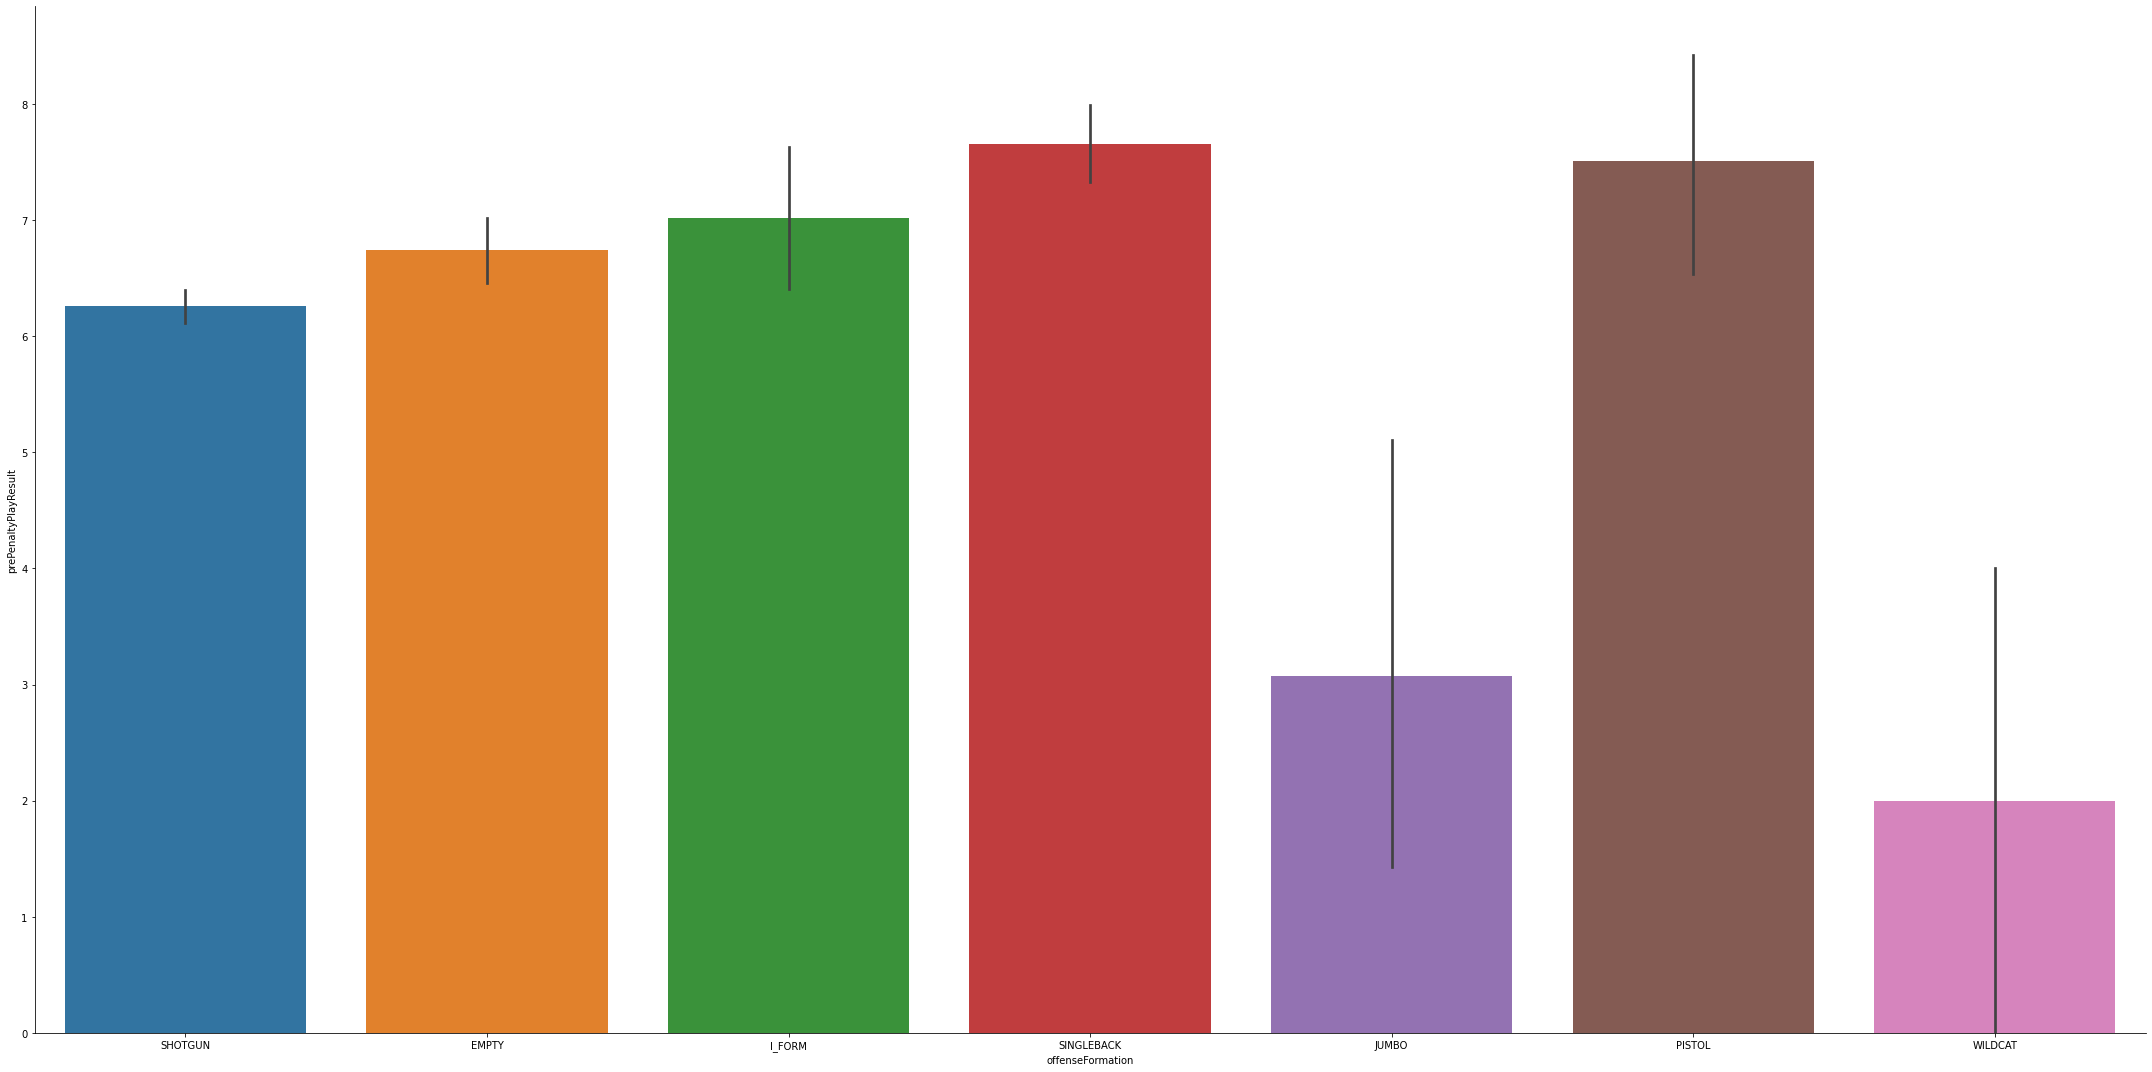

In [68]:
sns.catplot(x='offenseFormation', y='prePenaltyPlayResult', kind='bar',data=df_eda_cov, height=15, aspect=2)

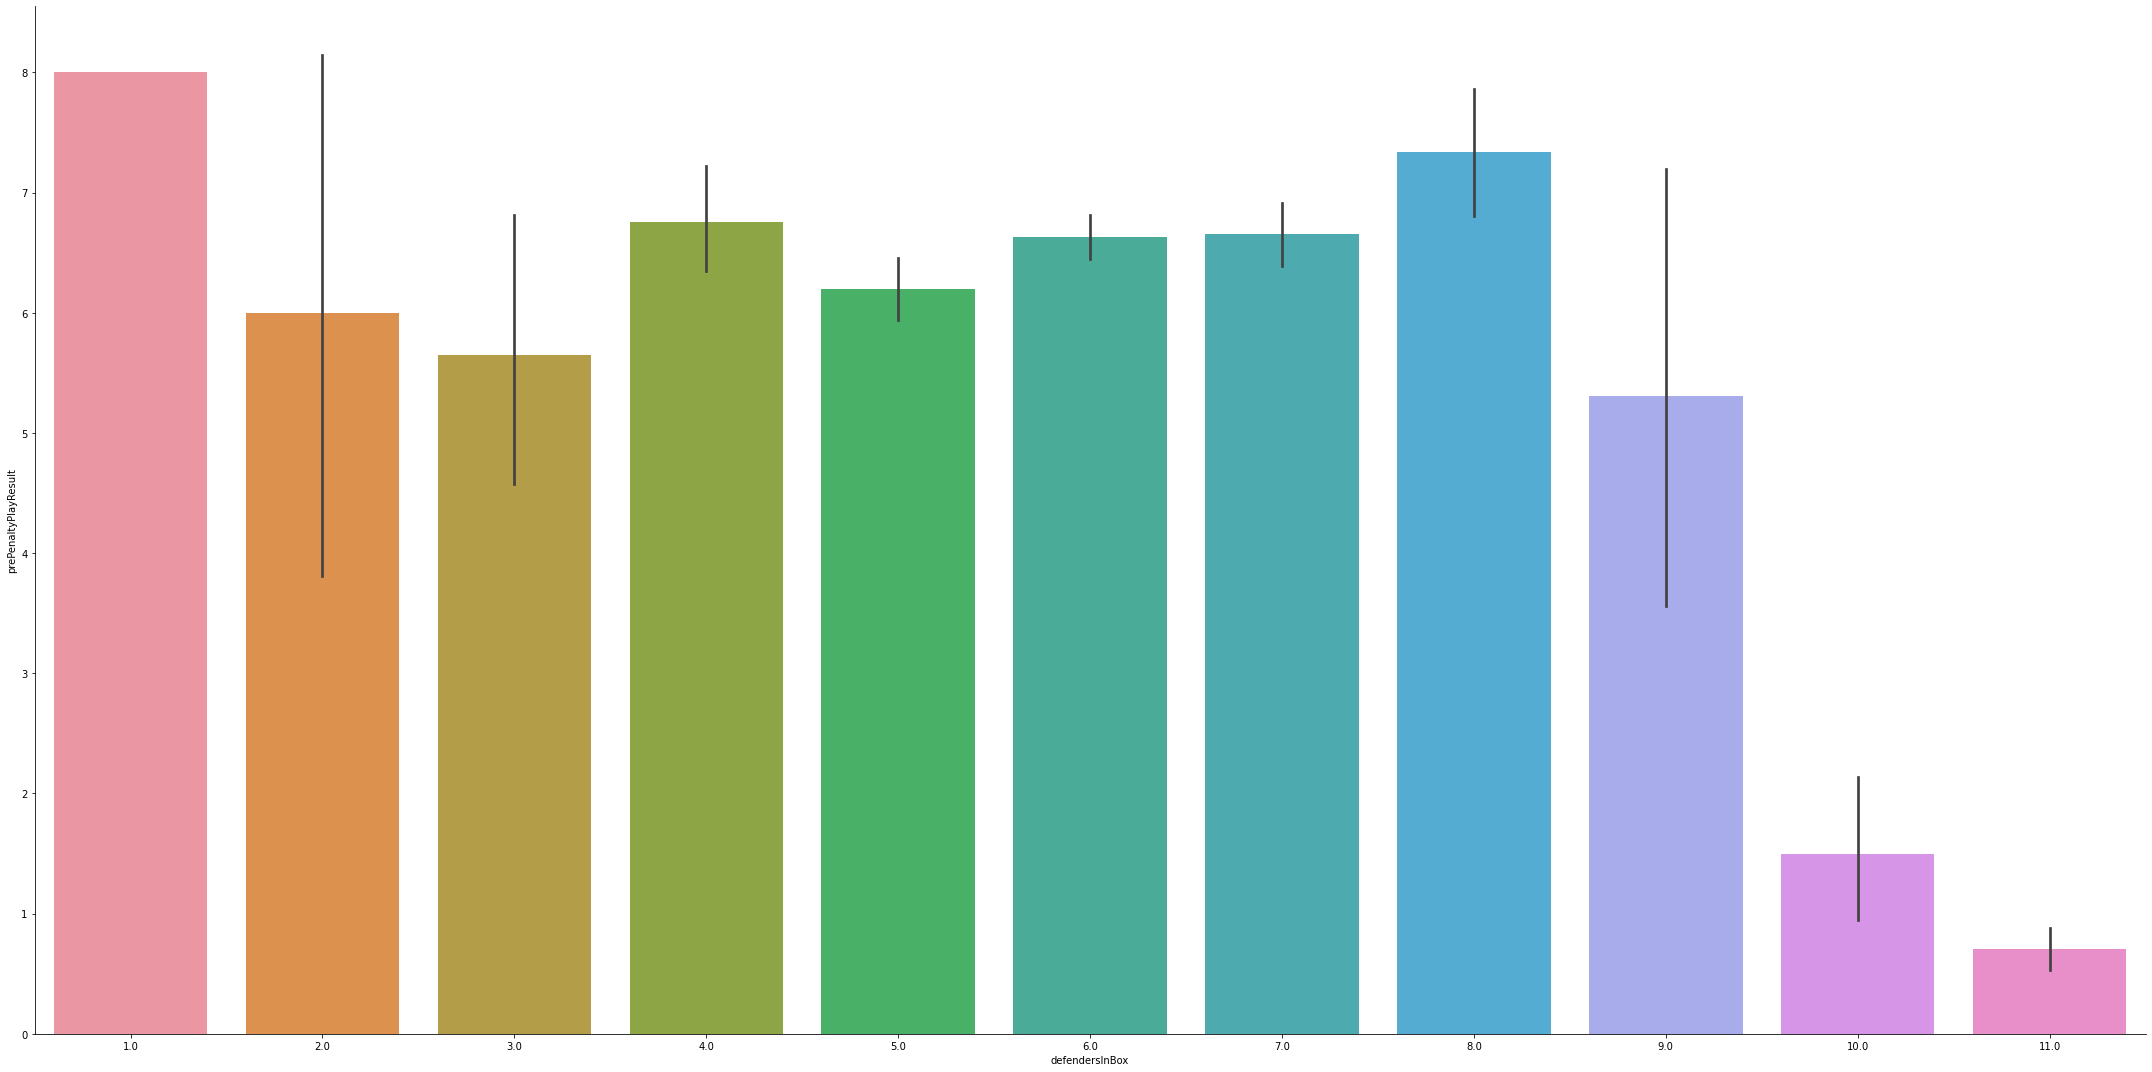

In [69]:
sns.catplot(x='defendersInBox', y='prePenaltyPlayResult', kind='bar',data=df_eda_cov, height=15, aspect=2)

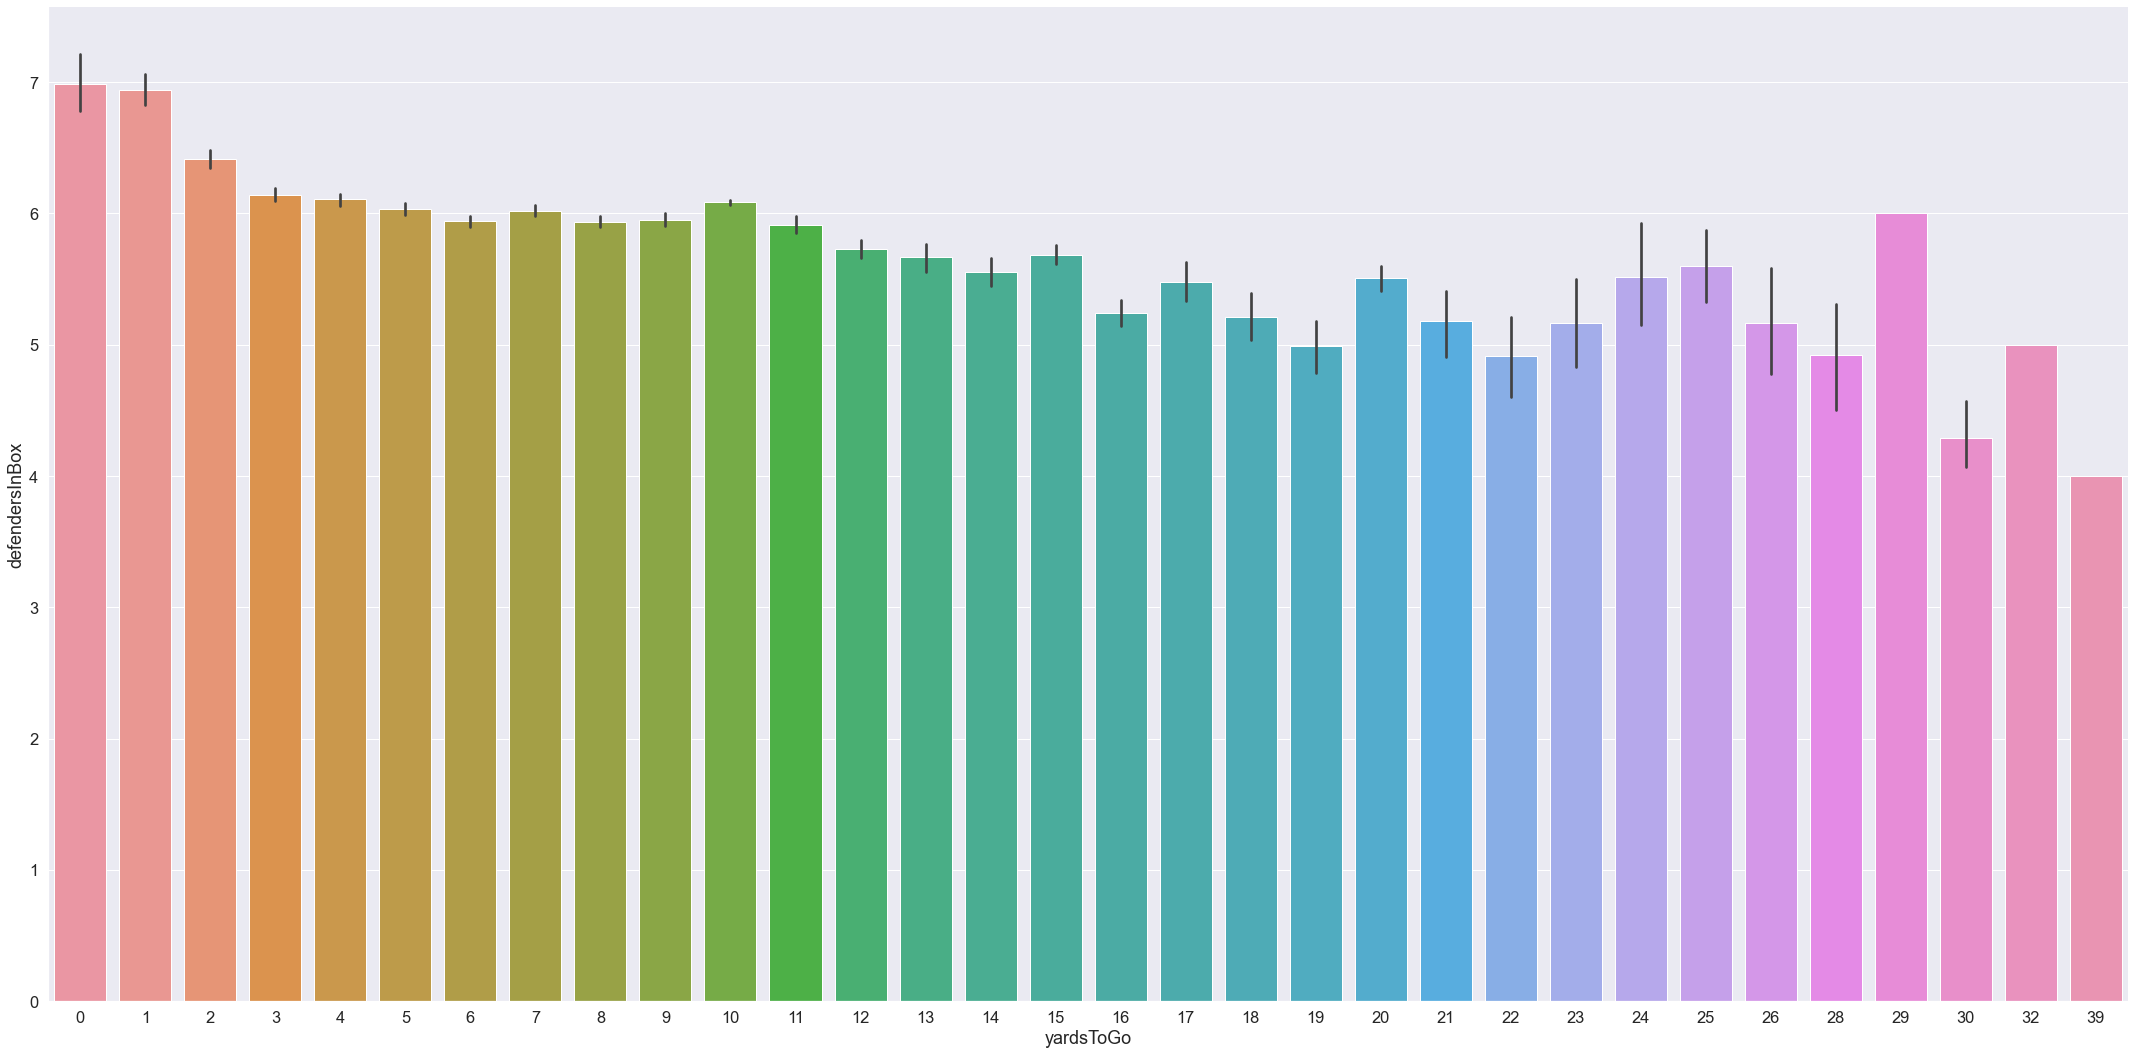

In [140]:
sns.catplot(x='yardsToGo', y='defendersInBox', kind='bar',data=df_eda_cov, height=15, aspect=2)

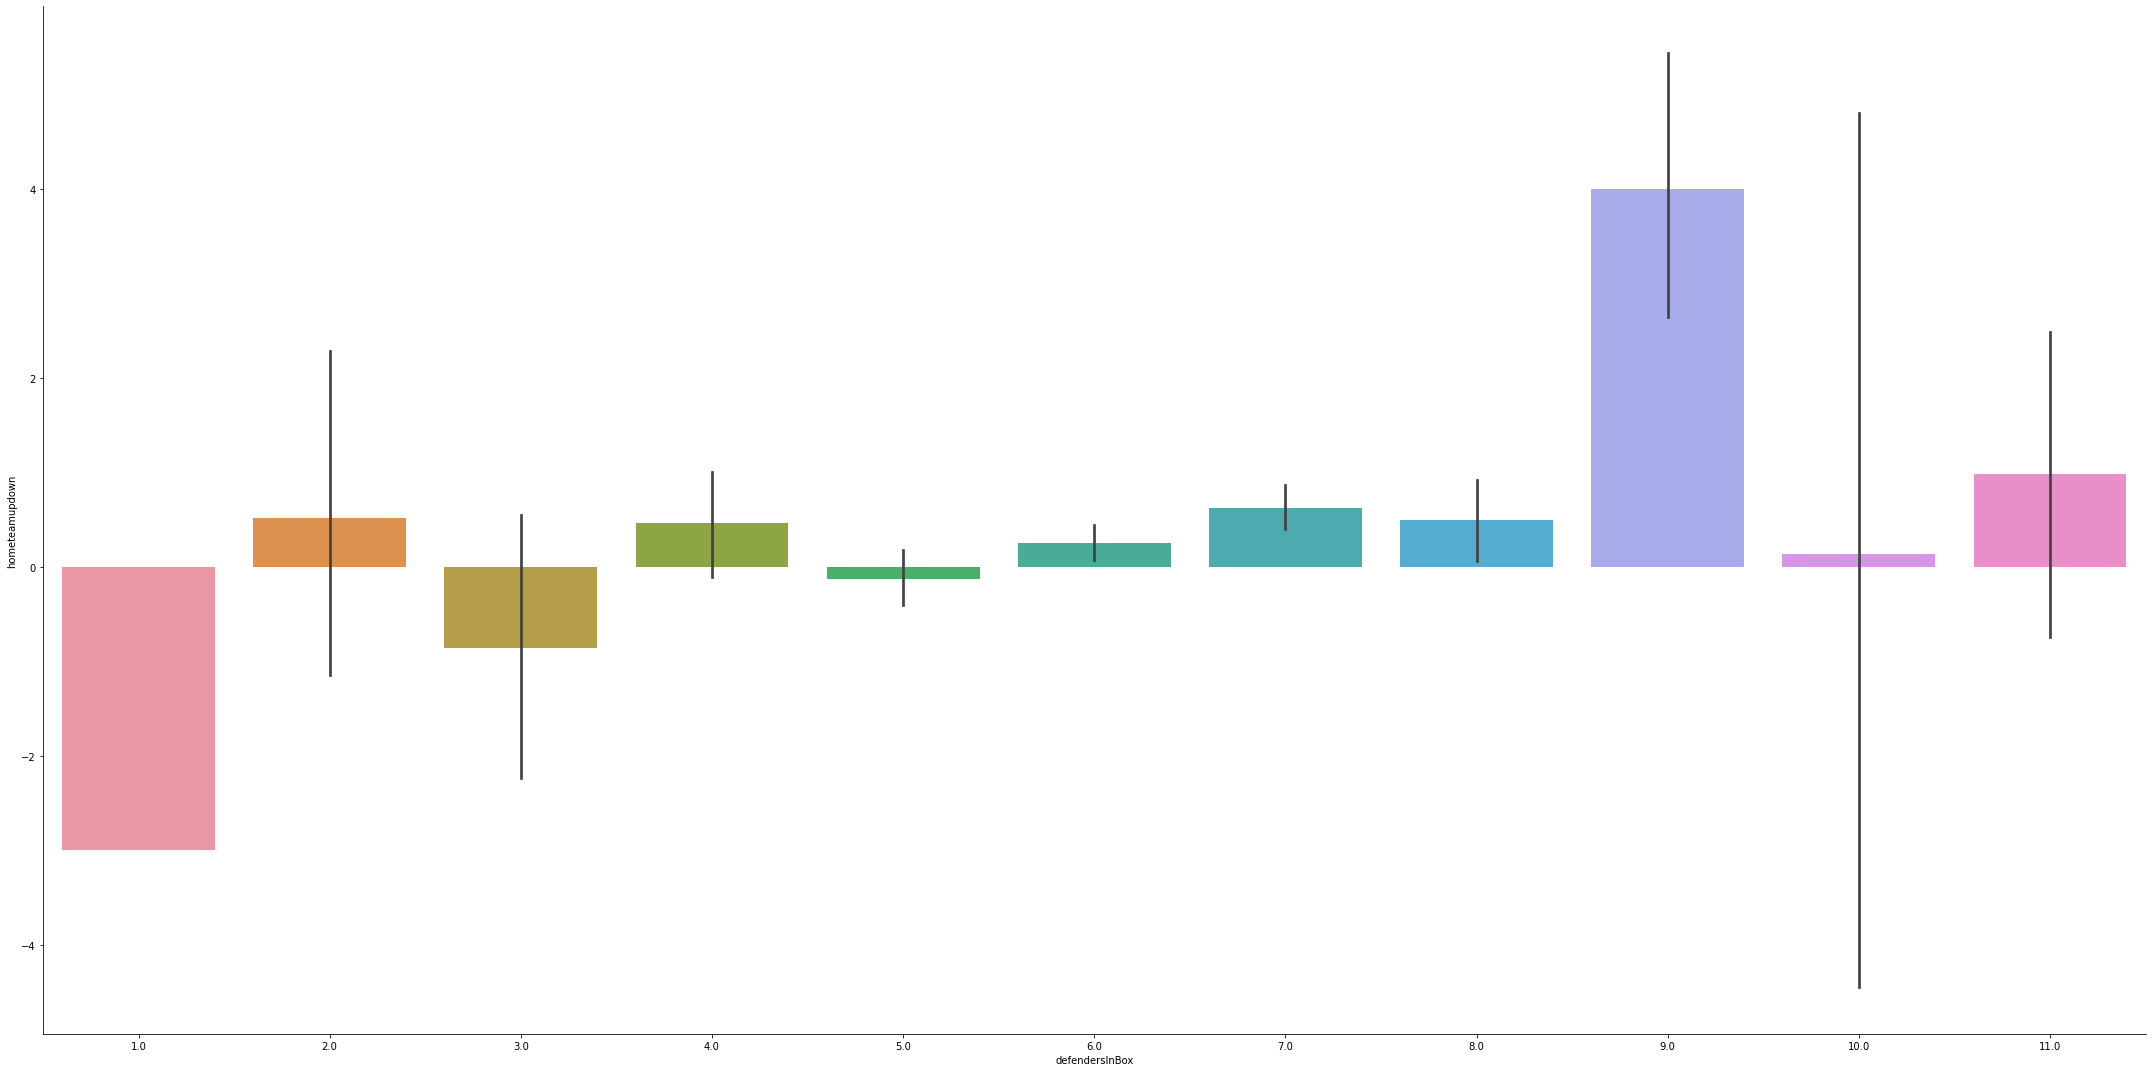

In [78]:
sns.catplot(x='defendersInBox', y='hometeamupdown', kind='bar',data=df_eda_cov, height=15, aspect=2)

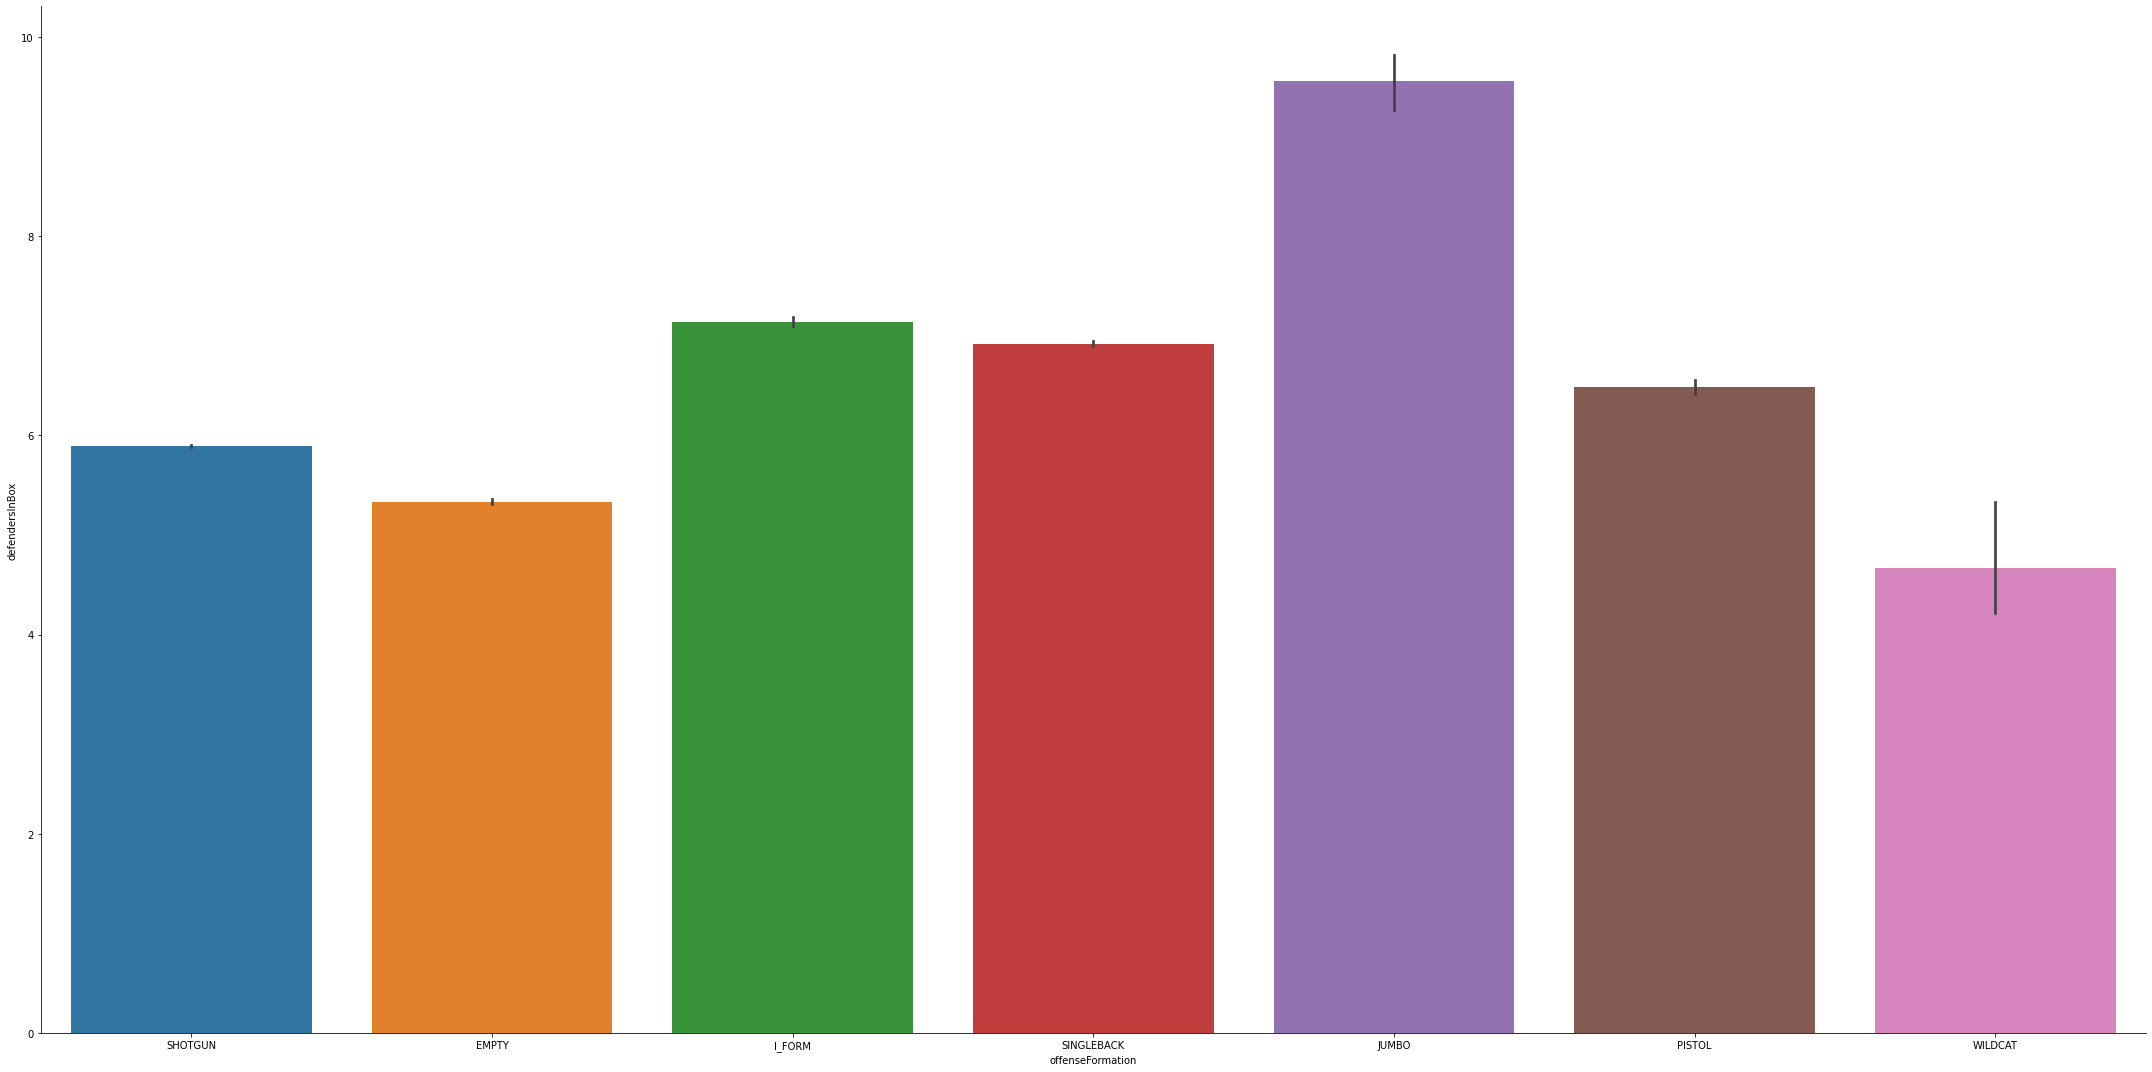

In [79]:
sns.catplot(x='offenseFormation', y='defendersInBox', kind='bar',data=df_eda_cov, height=15, aspect=2)

In [89]:
df_eda_cov_dummy = pd.get_dummies(data=df_eda_cov, columns=['pff_blockType', 'pff_passCoverageType', 'offenseFormation', 'dropBackType', 'passResult'])
df_eda_cov_dummy

,gameId,playId,yardsToGo,preSnapHomeScore,defendersInBox,preSnapVisitorScore,prePenaltyPlayResult,playResult,hometeamupdown,pff_blockType_BH,...,dropBackType_SCRAMBLE,dropBackType_SCRAMBLE_ROLLOUT_LEFT,dropBackType_SCRAMBLE_ROLLOUT_RIGHT,dropBackType_TRADITIONAL,dropBackType_UNKNOWN,passResult_C,passResult_I,passResult_IN,passResult_R,passResult_S
0,2021092604,1330,0,0,11.0,12,0,0,-12.0,0,...,0,0,0,0,0,1,0,0,0,0
1,2021092604,1330,0,0,11.0,12,0,0,-12.0,0,...,0,0,0,0,0,1,0,0,0,0
2,2021092604,1330,0,0,11.0,12,0,0,-12.0,0,...,0,0,0,0,0,1,0,0,0,0
3,2021103103,2868,0,10,4.0,9,0,0,1.0,0,...,0,0,0,0,0,0,1,0,0,0
4,2021103103,2868,0,10,4.0,9,0,0,1.0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30631,2021102401,1007,9,7,8.0,7,10,10,0.0,0,...,0,0,0,1,0,1,0,0,0,0
30632,2021102401,1007,9,7,8.0,7,10,10,0.0,0,...,0,0,0,1,0,1,0,0,0,0
30633,2021091202,1885,9,9,5.0,0,14,14,9.0,0,...,0,0,0,1,0,1,0,0,0,0
30634,2021091202,1885,9,9,5.0,0,14,14,9.0,0,...,0,0,0,1,0,1,0,0,0,0


<AxesSubplot:>

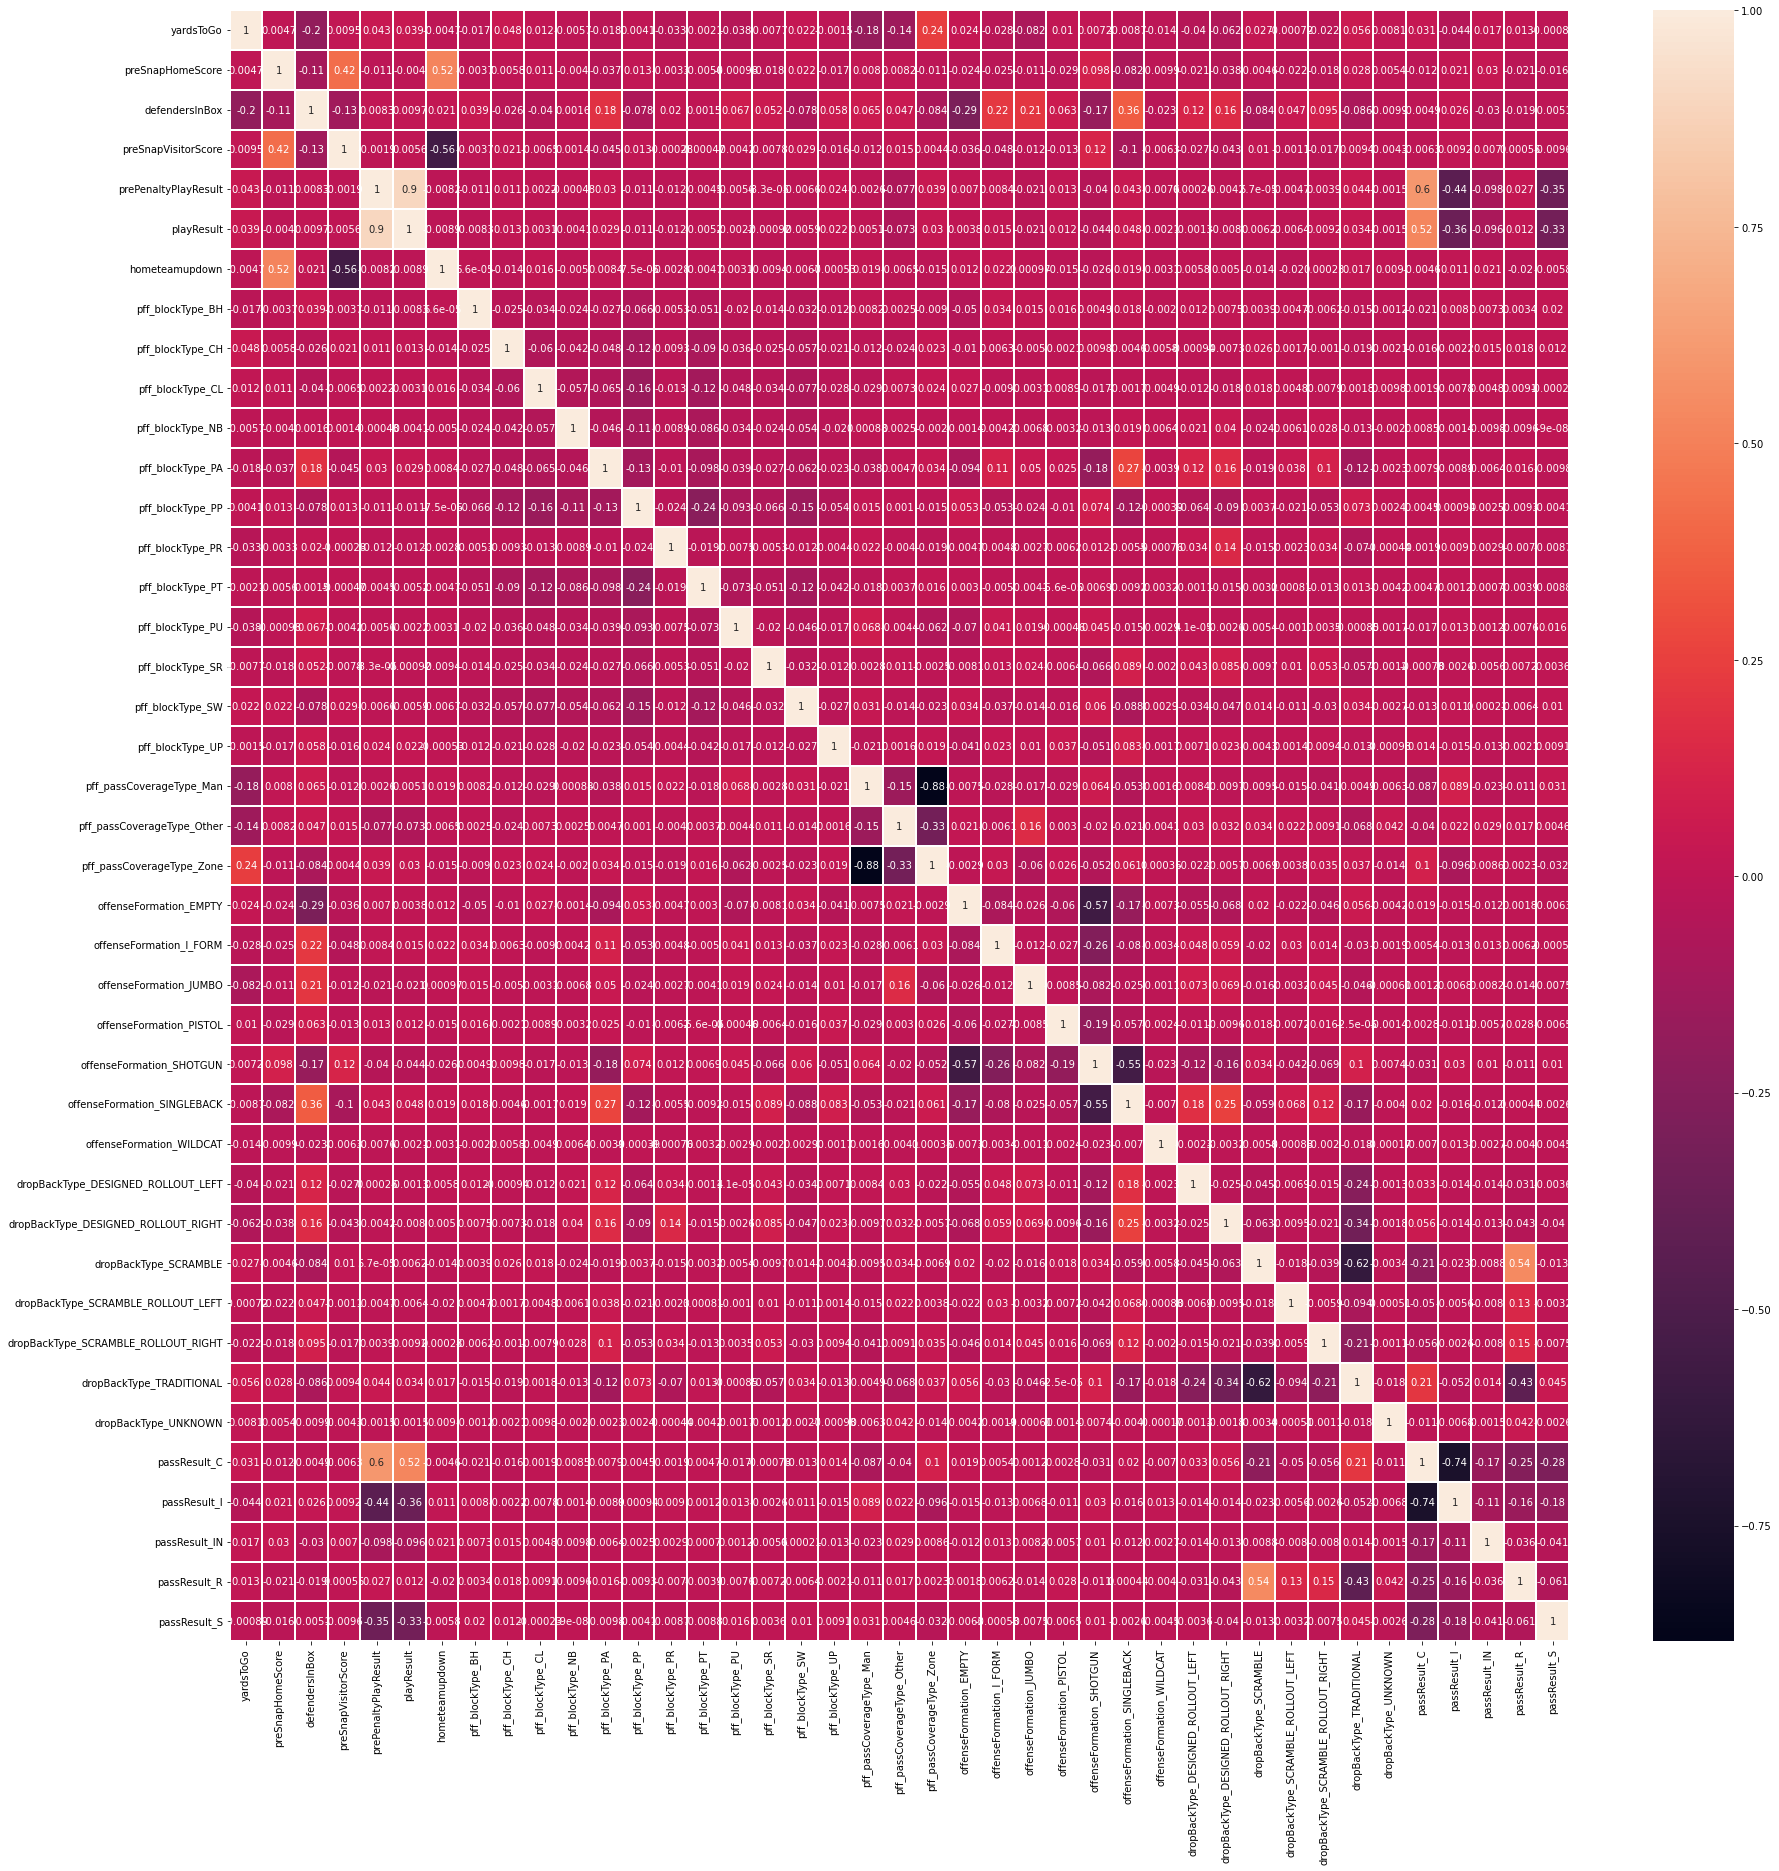

In [92]:
fig, ax = plt.subplots(figsize=(30,30))
sns.heatmap(df_eda_cov_dummy.corr(),linewidths=.05, annot=True, ax=ax)

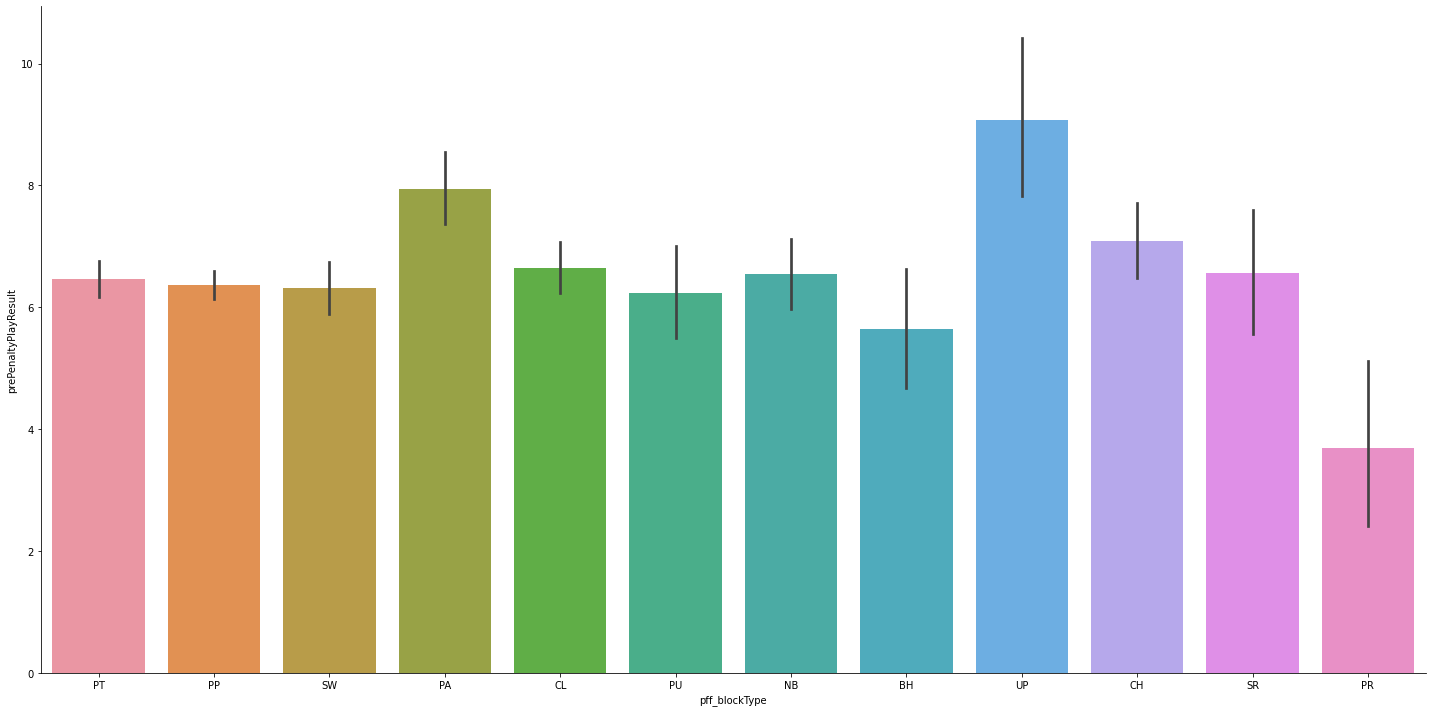

In [97]:
sns.catplot(x='pff_blockType', y='prePenaltyPlayResult', kind='bar',data=df_eda_cov, height=10, aspect=2)

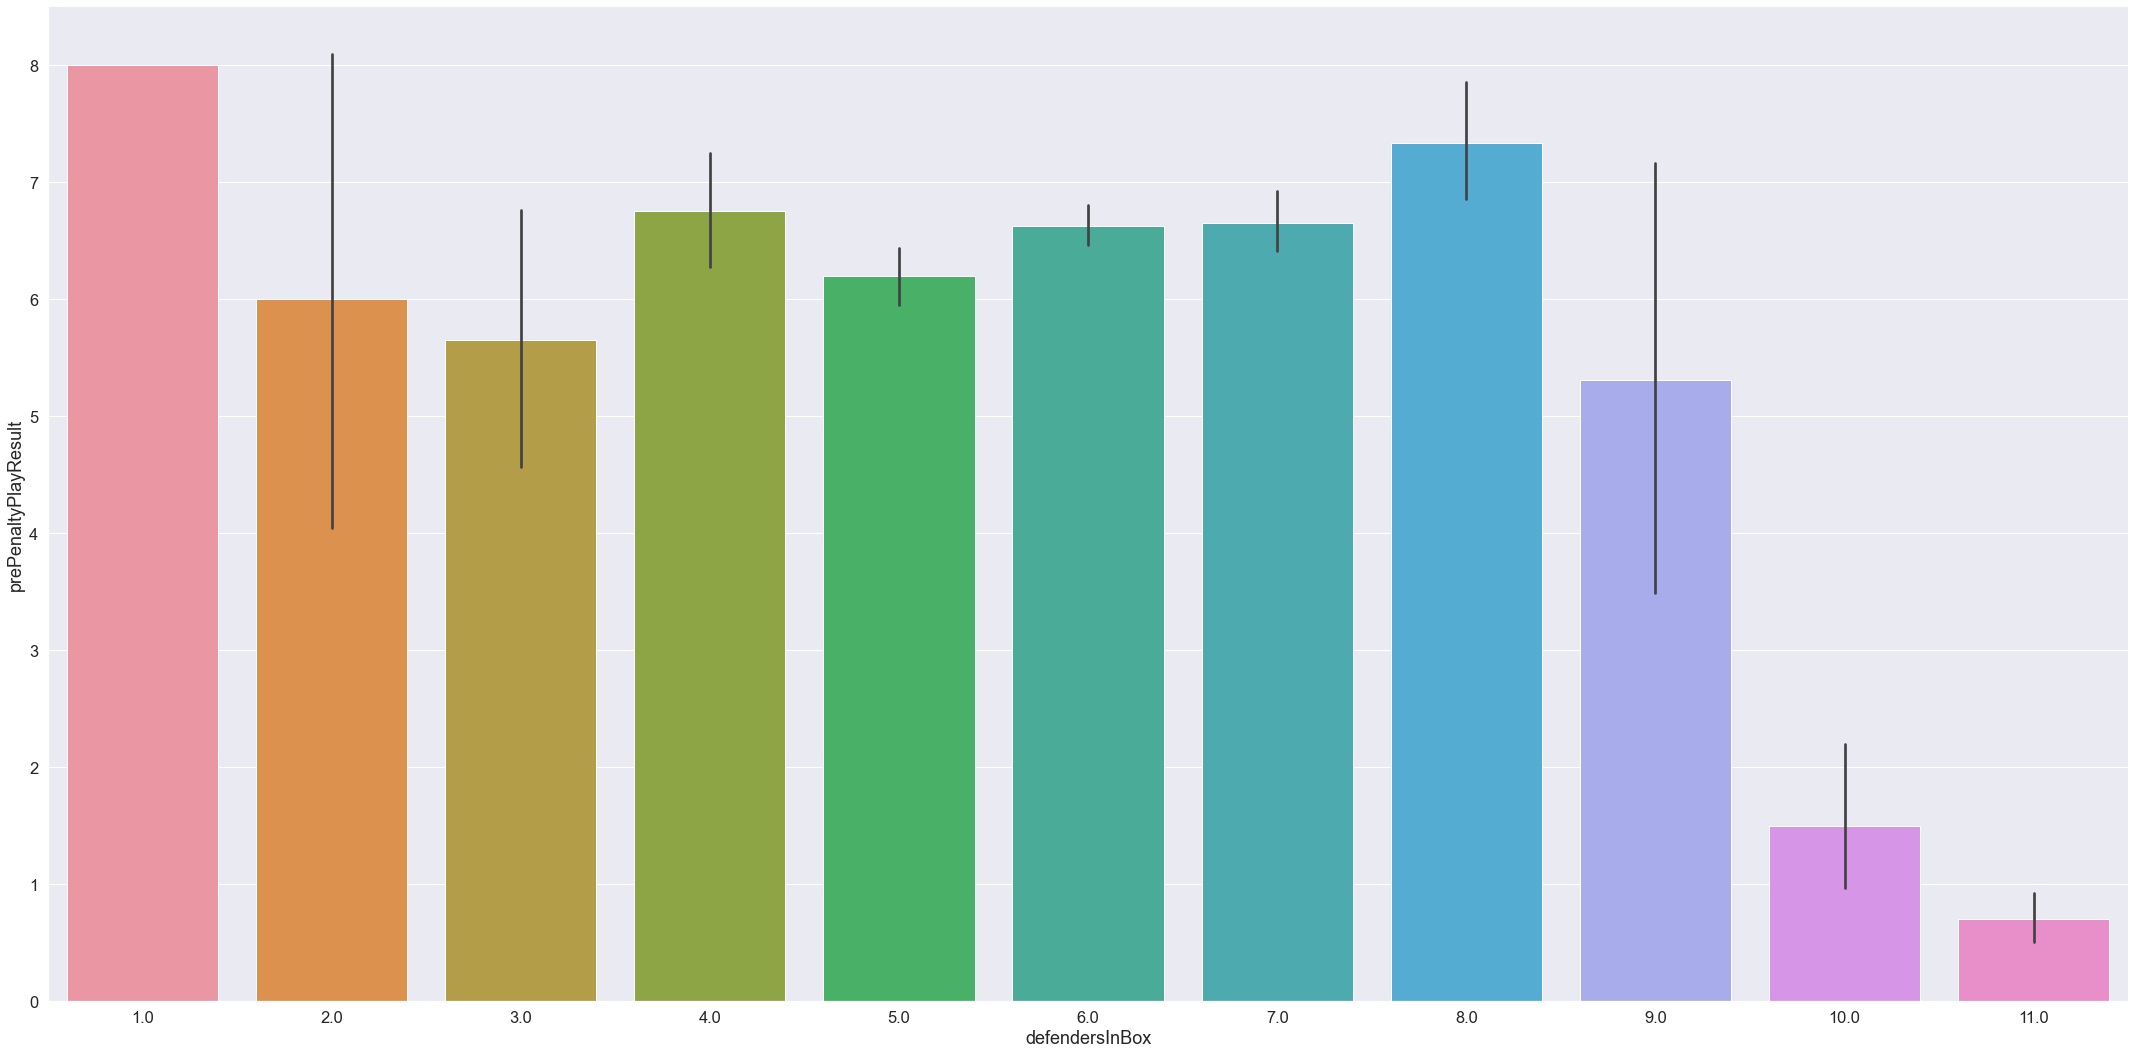

In [137]:
sns.catplot(x='defendersInBox', y='prePenaltyPlayResult', kind='bar',data=df_eda_cov, height=15, aspect=2)

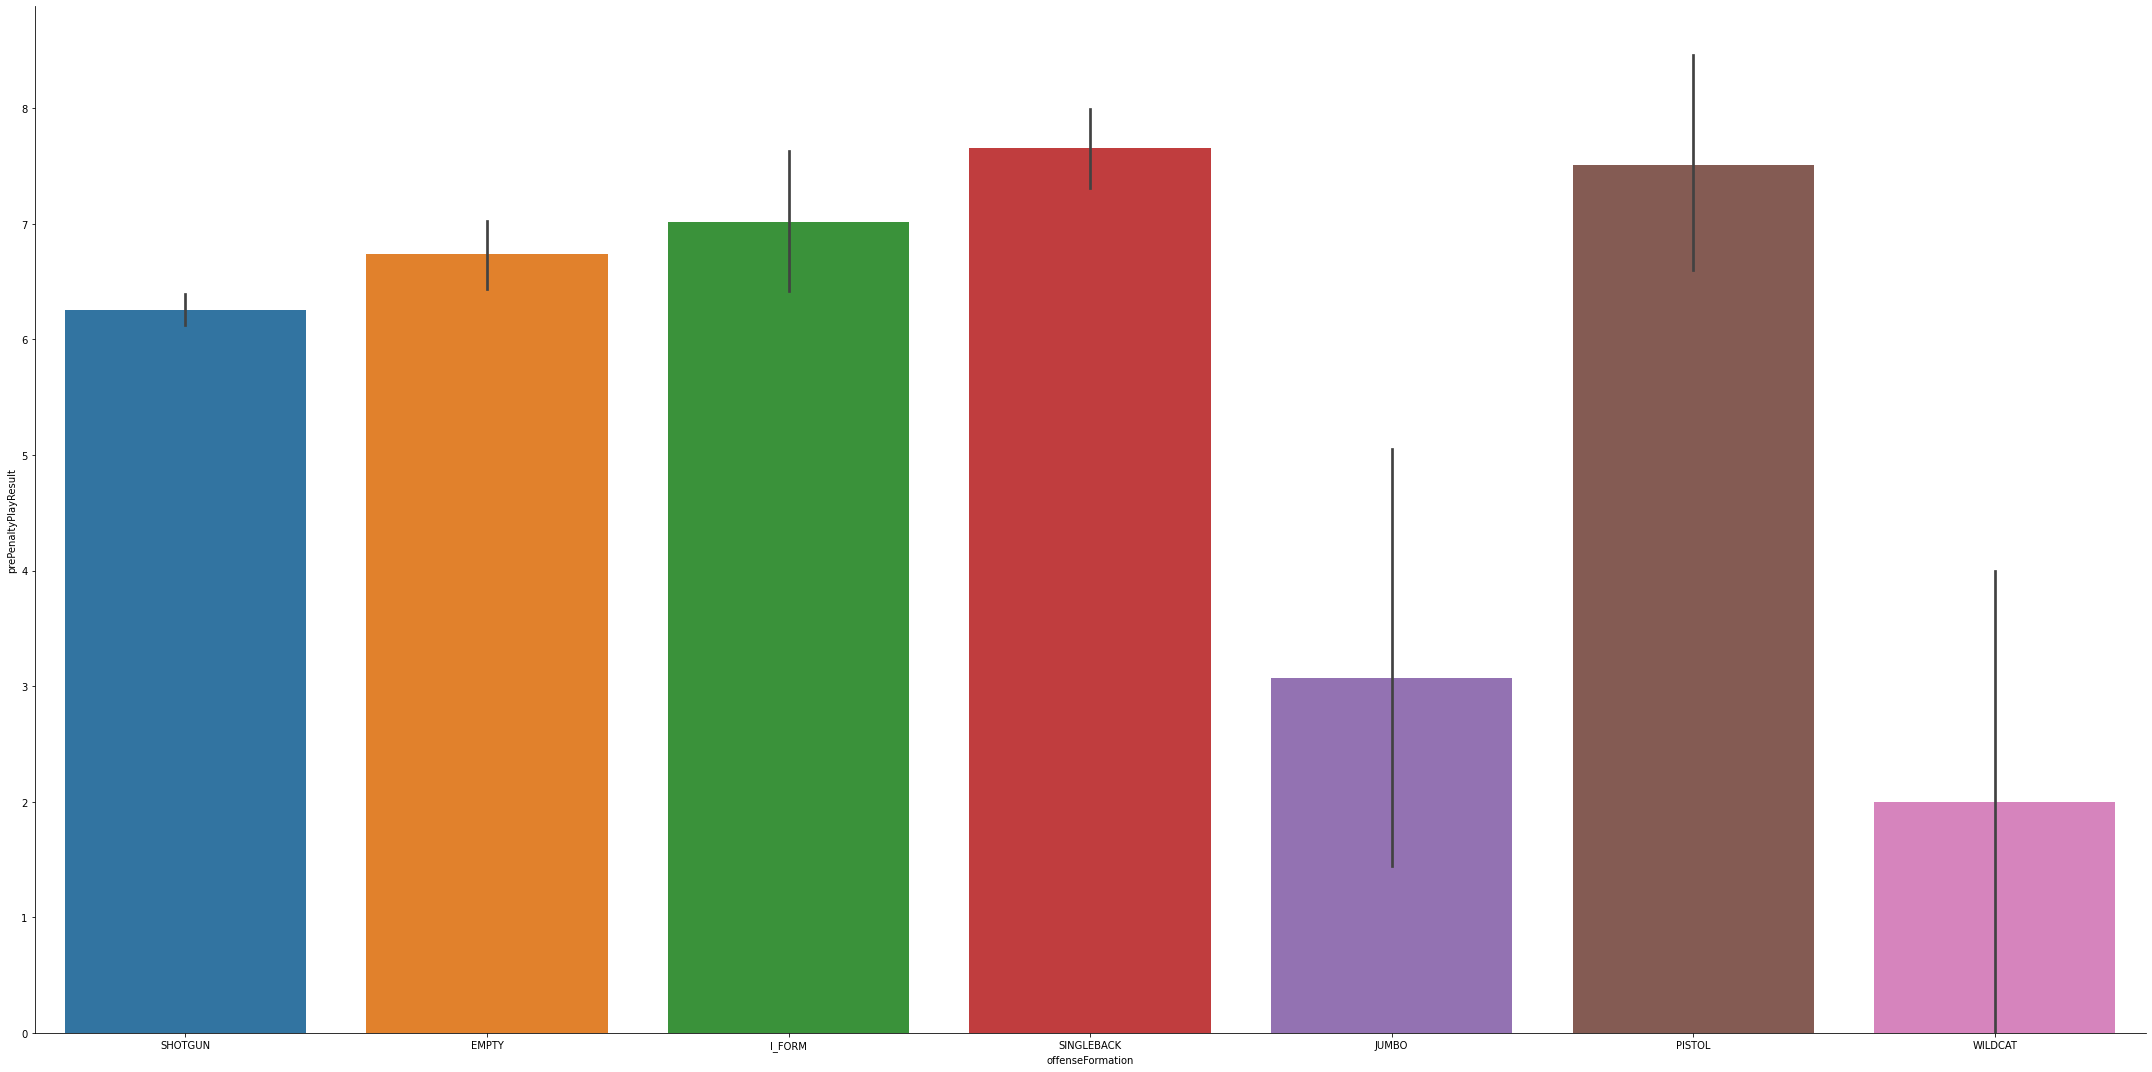

In [100]:
sns.catplot(x='offenseFormation', y='prePenaltyPlayResult', kind='bar',data=df_eda_cov, height=15, aspect=2)

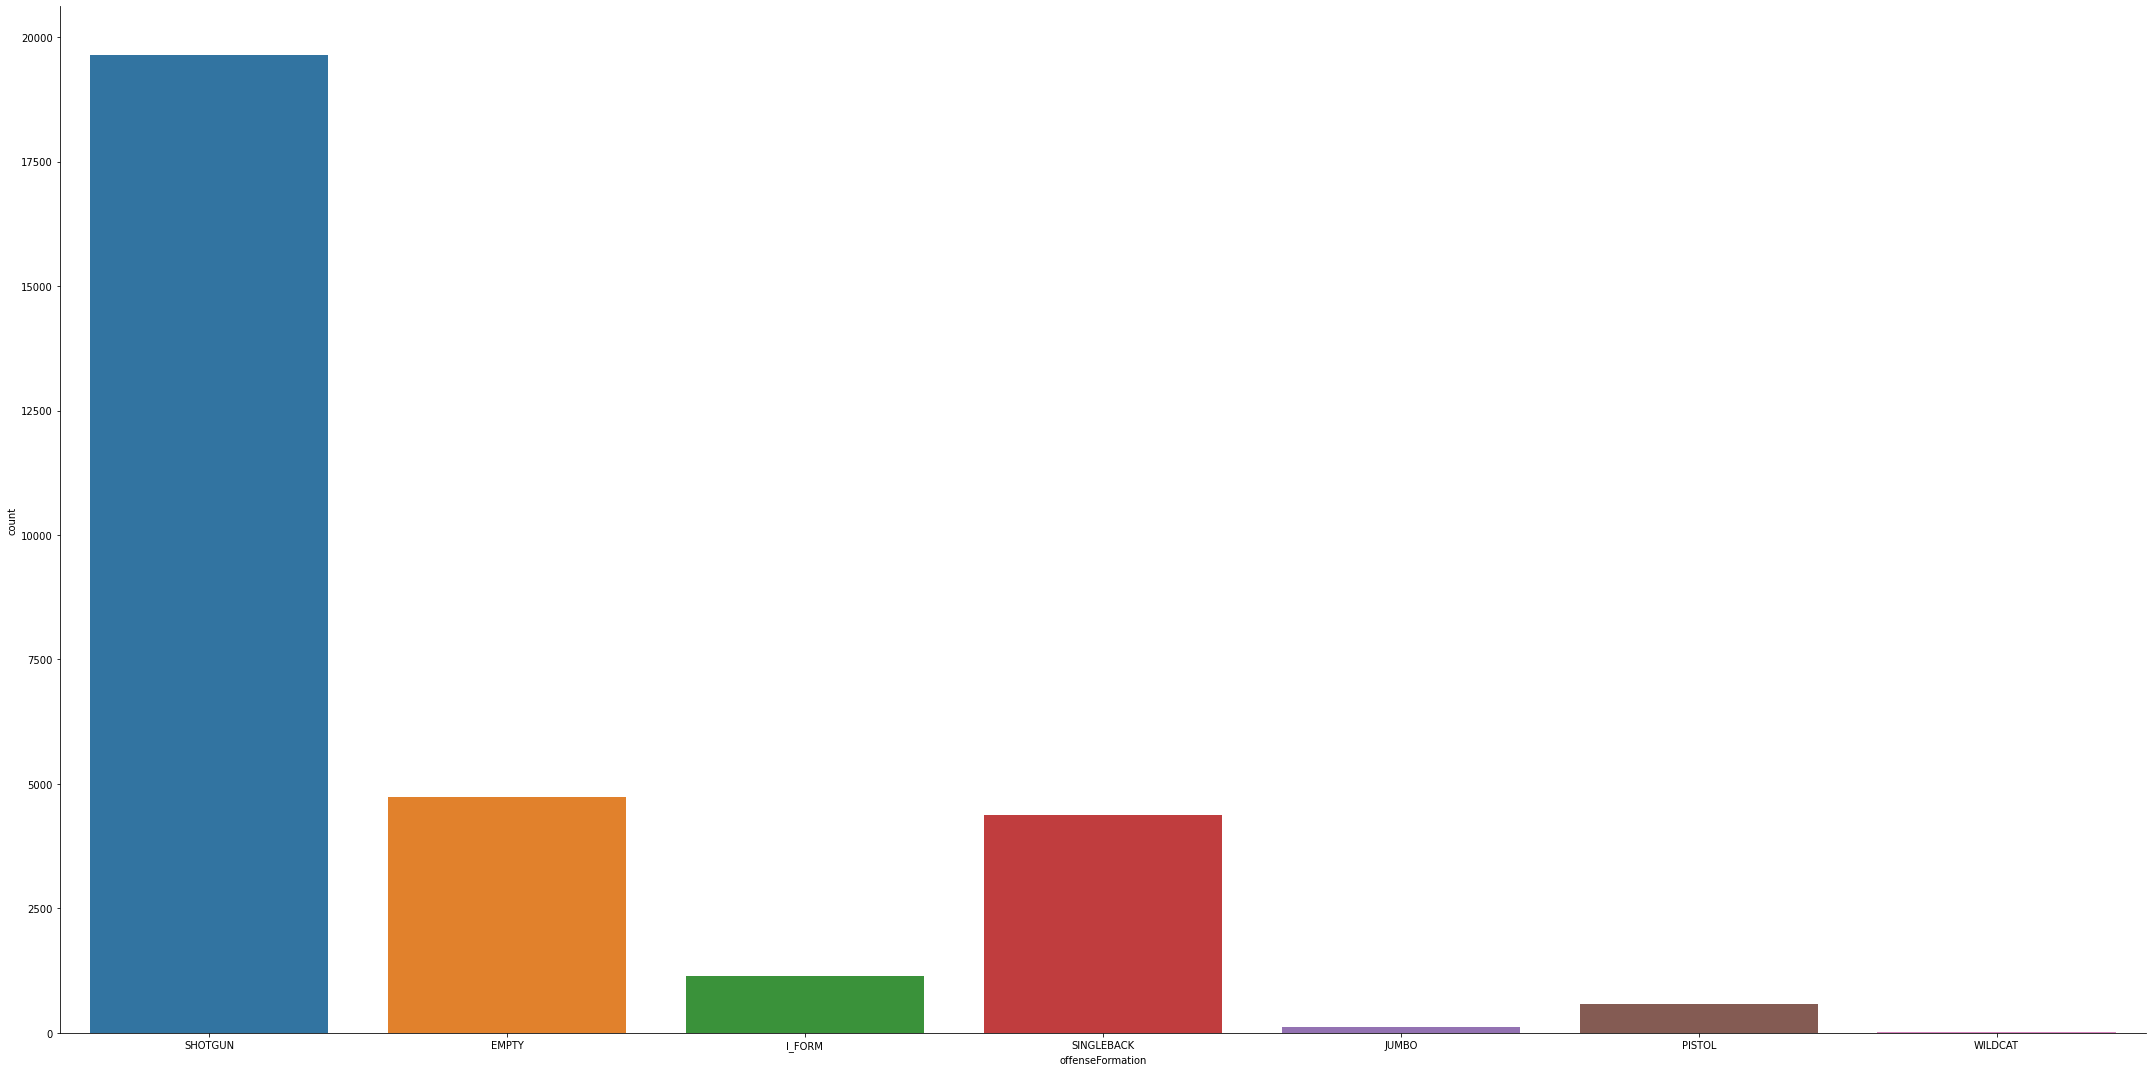

In [105]:
sns.catplot(x='offenseFormation', kind='count',data=df_eda_cov, height=15, aspect=2)

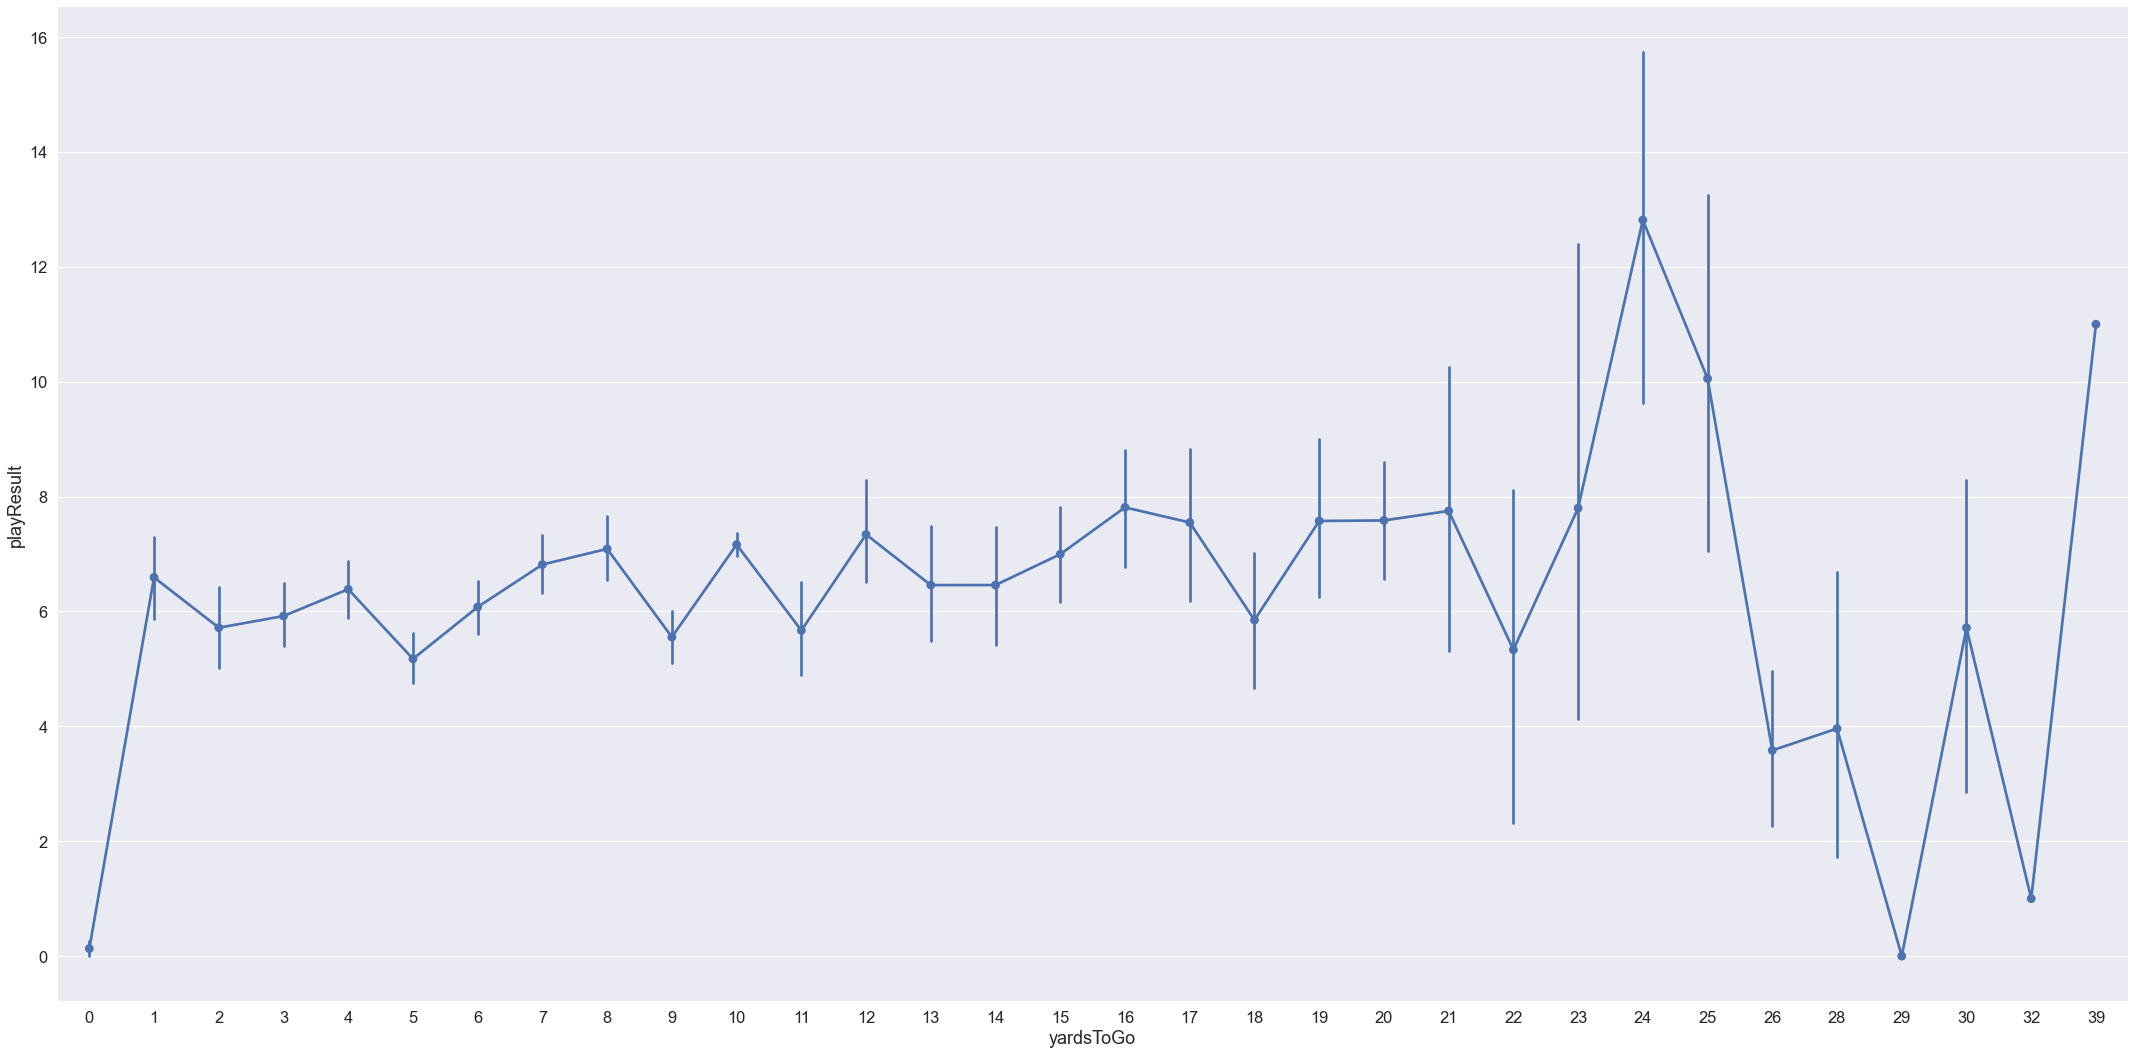

In [129]:
sns.catplot(x='yardsToGo',y='playResult', kind='point',data=df_eda_cov, height=15, aspect=2)

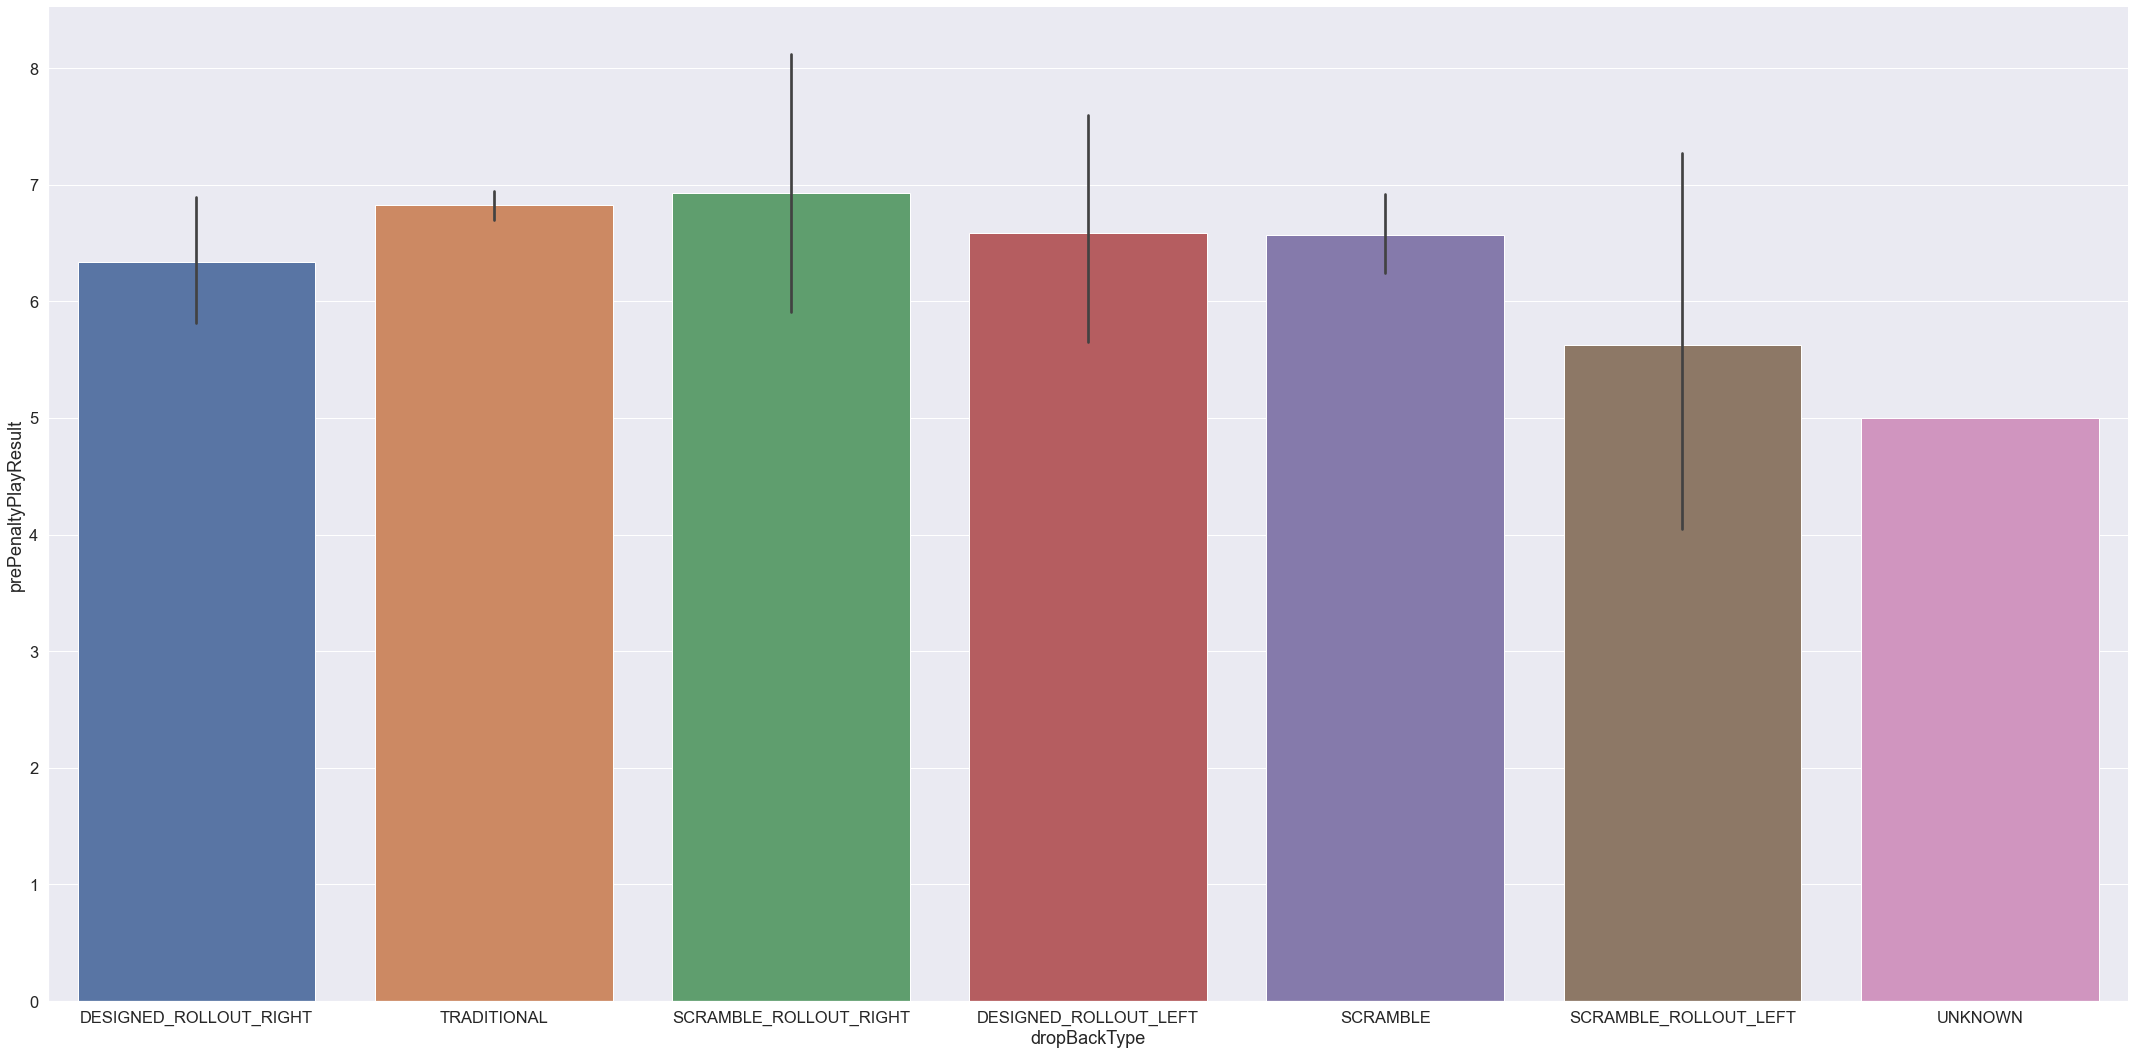

In [132]:
sns.catplot(x='dropBackType',y='prePenaltyPlayResult', kind='bar',data=df_eda_cov, height=15, aspect=2)

## Conclusion

There was plenty of insightful information I gained from this analysis. I will be using this data to set up the pre-processing step of the machine learning process. Some insights include:

1. Running Singleback or Pistol offensive formation leads to a higher average yards gained result vs running Jumbo or wildcat formation
2. When there are 9,10, or 11 defenders in the box, the average pass result is significantly lower
3. Offensive linemen using UP block allow for more passing yards on average vs offensinve linemen using any other block type
4. There are no significantly strong relationships (negative or positive) among the different features within this dataset. 
5. When the offense is using Wildcat formation, on average, the defense puts the least amount of defenders in the box. But when the offense is using JUMBO formation, one average, defense puts the most amount of defenders in the box.
6. Singleback and Pistol formation have the highest average yards gained per play
7. There is no relationship between yards gained and the length of a play - has a p-value significantly lower than 0.05
8. On average, the more yards needed to gain for first down, the lower the number of defenders that'll be in the box